In [1]:
%run init_notebookspace.py
from settings import *

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import statsmodels.api as sm
import statsmodels
import scipy

from src.utils import time_format, plot_df, get_seasonal_hp, arr_adf, apply_func, poly_detrend, ADF_test_summary
from src.utils import get_max_seasonal, OLS_dummie_deseasonal

config = {
    'figure.figsize':(14,4),
    'figure.dpi':144,
    'figure.facecolor':'white',
    'axes.grid':True,
    'grid.linestyle':'--',
    'grid.linewidth':0.5,
    'axes.spines.top':False,
    'axes.spines.bottom':False,
    'axes.spines.left':False,
    'axes.spines.right':False
}

plt.rcParams.update(config)

# Table of contents

* [Get Italy data](#chapter1)
* [Preprocessing the data](#chapter2)
    * [Train Test Split](#section_2_1)
    * [Log-Transformation of the Data](#section_2_2)
    * [Detrend the Data](#section_2_3)
    * [Deseasonalize the Data](#section_2_4)
        * [OLS method](#subsection_1)
        * [HP filter](#subsection_2)

## Get Italy data <a class="anchor" id="chapter2"></a>

Once built a complete dataset in csv format, here we import series for consumption, investment, labor (in the form hours worked), GDP (at current prices, non deseasonalized), real interest rate , and wages (for non farm workers).

In [3]:
data = pd.read_csv(os.path.join(DATA_DIR, "all_rbc_data.csv"), infer_datetime_format="QS")
data["TIME"] = time_format(data.TIME)
data.set_index("TIME", drop=True, inplace=True)
data.sort_index(inplace=True)

# assign new column names
data.rename(columns=dict(zip(data.columns, ["Y", "I", "Z", "X", "r", "C", "w", "L"])), inplace=True)

# drop exports imports, not required
data.drop(["X", "Z"], axis=1, inplace=True)

recs = np.load(os.path.join(DATA_DIR, 'recs.npy'))

In [4]:
glob_cols = list(data.columns)
plot_vars = ['A', 'C', 'I', 'L', 'Y', 'K', 'lambda', 'r', 'w']

## Prepocessing the Data <a class="anchor" id="chapter3"></a>

In this section more work on the data has been done; we have:
- split the data (as suggested) to have a train dataset to build the model and a test dataset to see if it works properly
- log linearized the variables
- detrend and deseasonalized the variables


In [5]:
# check for na
print(f"NaNs \n{data.isna().sum()}")

NaNs 
Y     0
I     0
r     0
C     0
w    36
L    70
dtype: int64


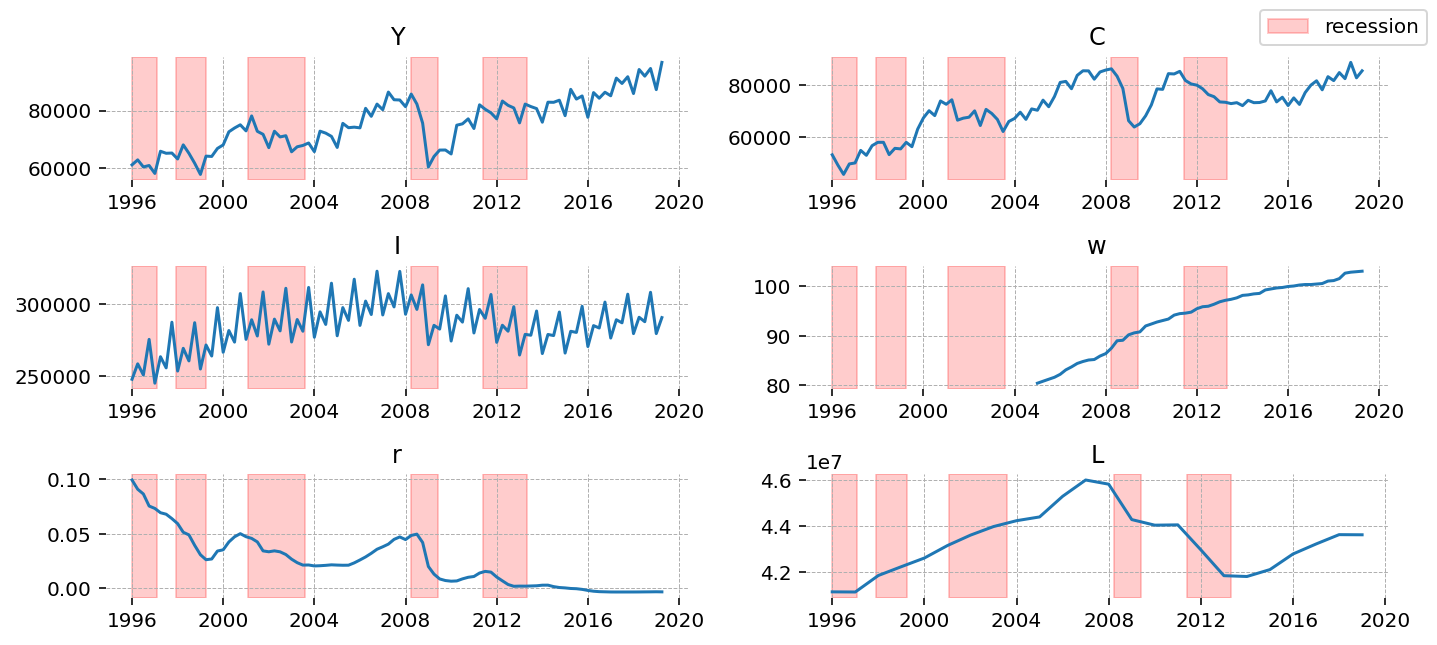

In [6]:
# raw data
plot_df(data, recs)

### Train Test Split <a class="anchor" id="section_2_1"></a>

We are splitting data into a testing and training data set, which will follow the same preprossesing. It is important to note that all data specific transformations applied to 'test' are based on the training data.

In [7]:
test_size = 0.15
test_index = len(data.index) - round(len(data.index) * test_size)
test_size = len(data) - test_index
print(f"Test size: {test_size} \nTrain size: {test_index}")

Test size: 14 
Train size: 80


In [8]:
train = data.iloc[:test_index].copy()
test = data.iloc[test_index:].copy()

### Log-transformation of the Data <a class="anchor" id="section_2_2"></a>

In [9]:
# log transform
for col in [item for item in glob_cols if item != "r"]:
    train[col] = apply_func(train[col], func=np.log)
    test[col] = apply_func(test[col], func=np.log)

Raw data is log transformed, thus somehow equalised in scale

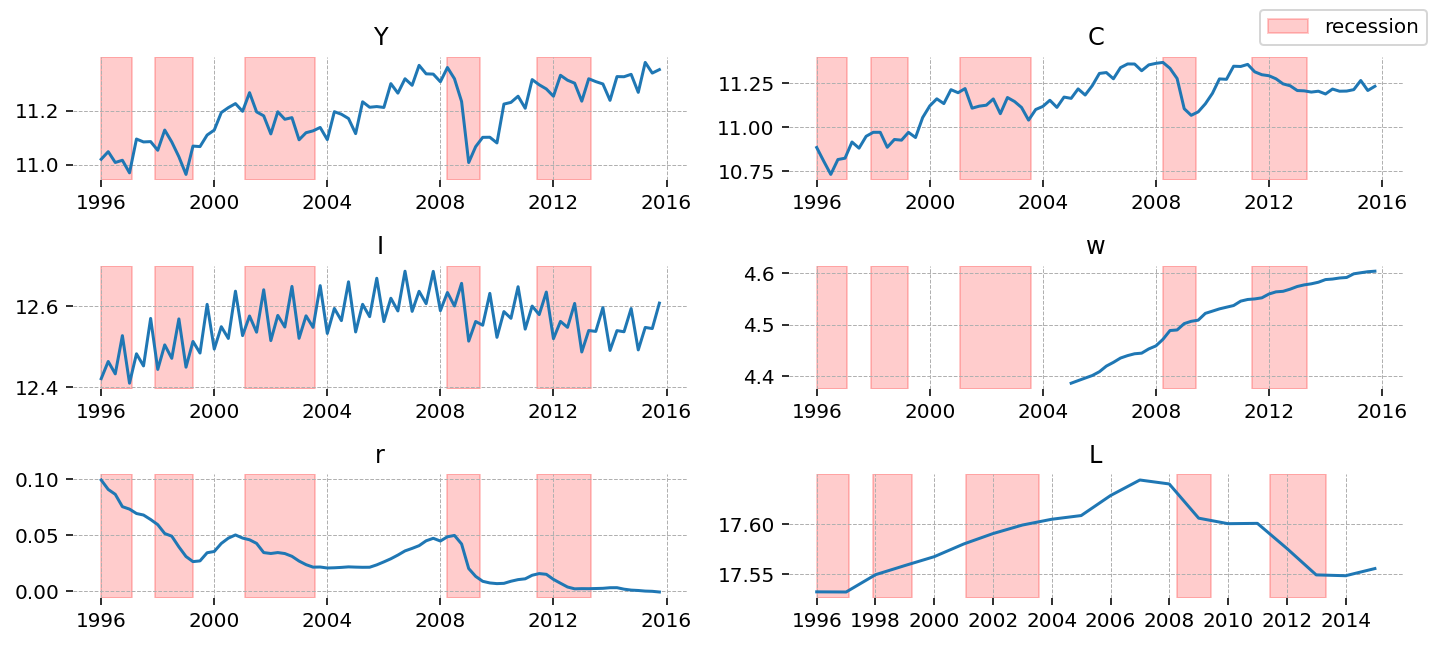

In [10]:
plot_df(train, recs)

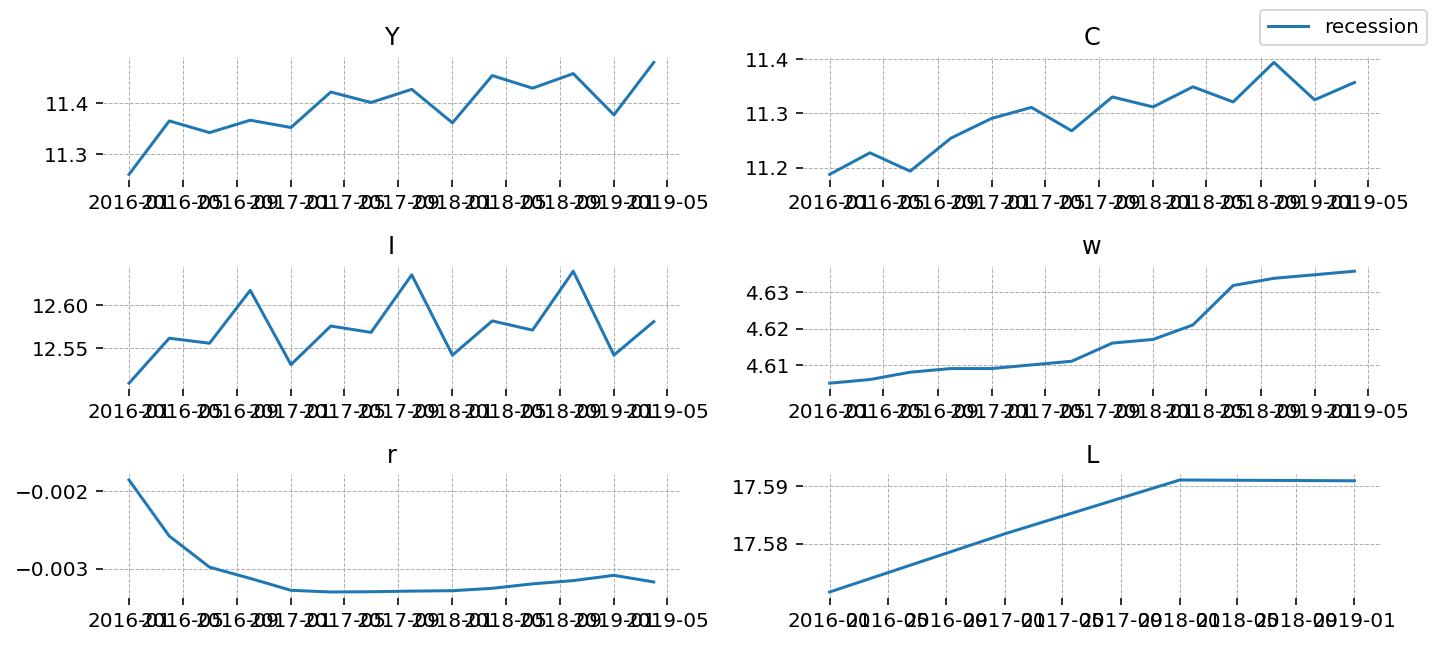

In [11]:
plot_df(test)

### Detrend the Data <a class="anchor" id="section_3_3"></a>

We apply a polynomial detrender to the data. Depending on the variables we have used polynomials of degree 1 or 2. The reason is that not every variables (look at the plots before) follow a clear linear trend. 
Interest rate is left out because it is set by CB thus no 'trend' in time series terms.

In [12]:
poly_order = {"Y": 1, 
              "C": 2, 
              "I": 2,
              "w": 1,
              "L": 2}
mask = train.copy()
for col in [item for item in glob_cols if item != 'r']:
    _ = train[col].dropna().copy()
    func_form = np.polyfit(list(range(0, len(_))), _, poly_order[col])
    
    train[col] = poly_detrend(train[col], poly_order=poly_order[col], skipna=True)   
    test[col] = poly_detrend(test[col], poly_order=poly_order[col], skipna=True)   
    mask[col] = poly_detrend(train[col], poly_order=poly_order[col], skipna=True, return_pred=True)
       
#     test[col] = np.polyval(func_form, test[col])

In [13]:
# interest rate is stationary at 10% level
ADF_test_summary(train['r'])

                                                      r                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.103         -3.340        0.060          1    -4.080      -3.468     -3.161
	Constant             0.005          2.620        0.011
	Trend               -0.000         -2.375        0.020
Constant Only               -0.043         -2.368        0.151          1    -3.517      -2.899     -2.587
	Constant             0.001          1.135        0.260
No Constant                 -0.027         -2.361        0.018          1    -2.595      -1.945     -1.614


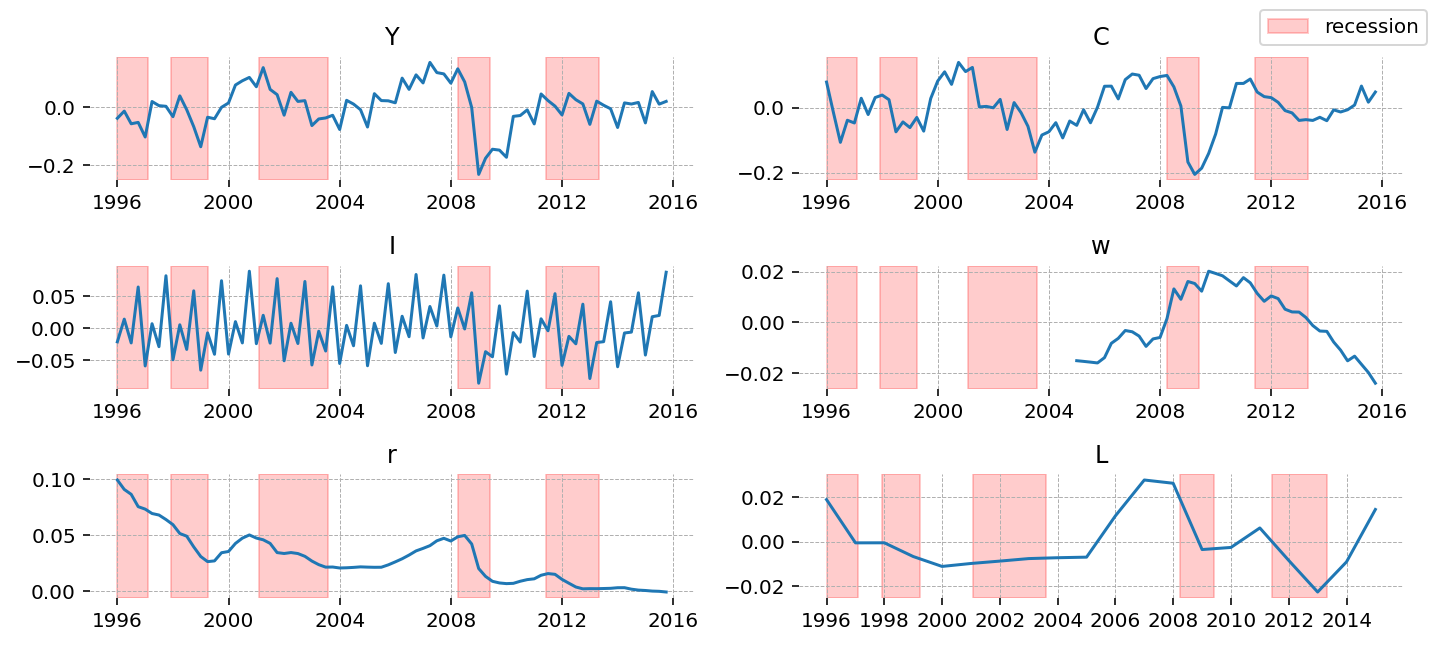

In [14]:
plot_df(train, recs)

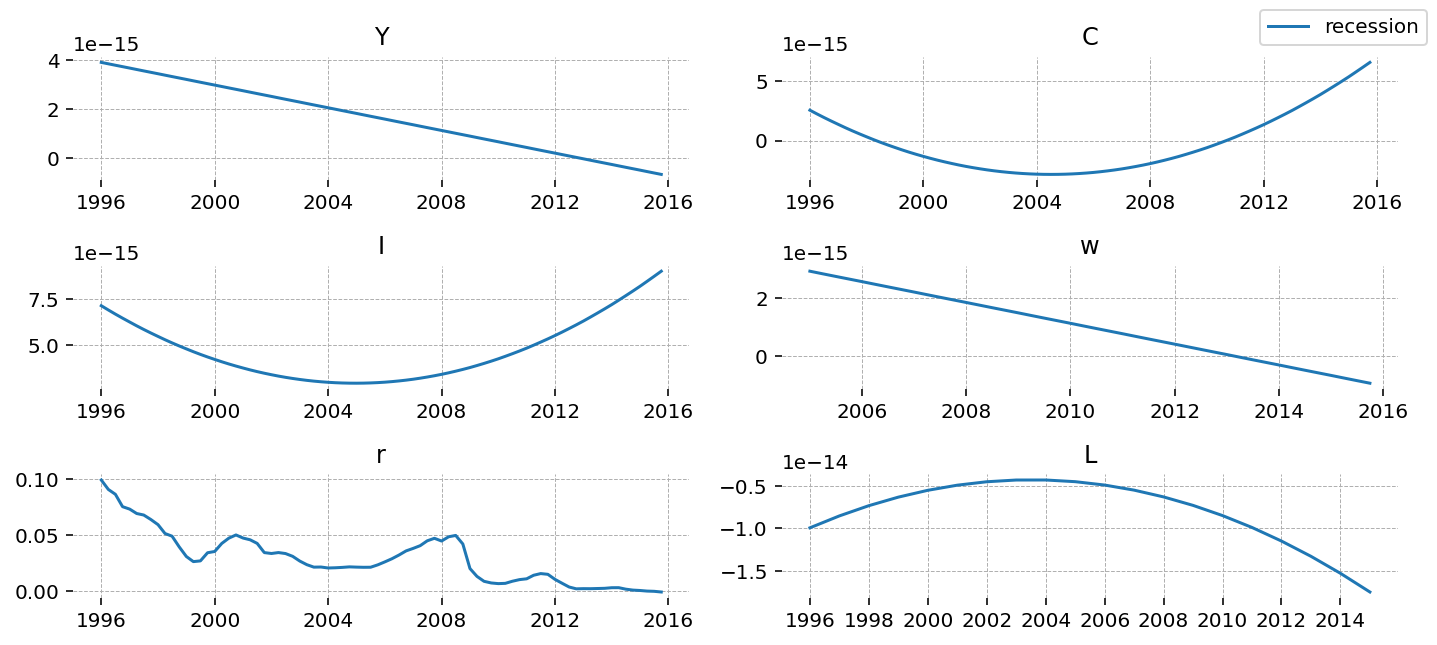

In [15]:
plot_df(mask)

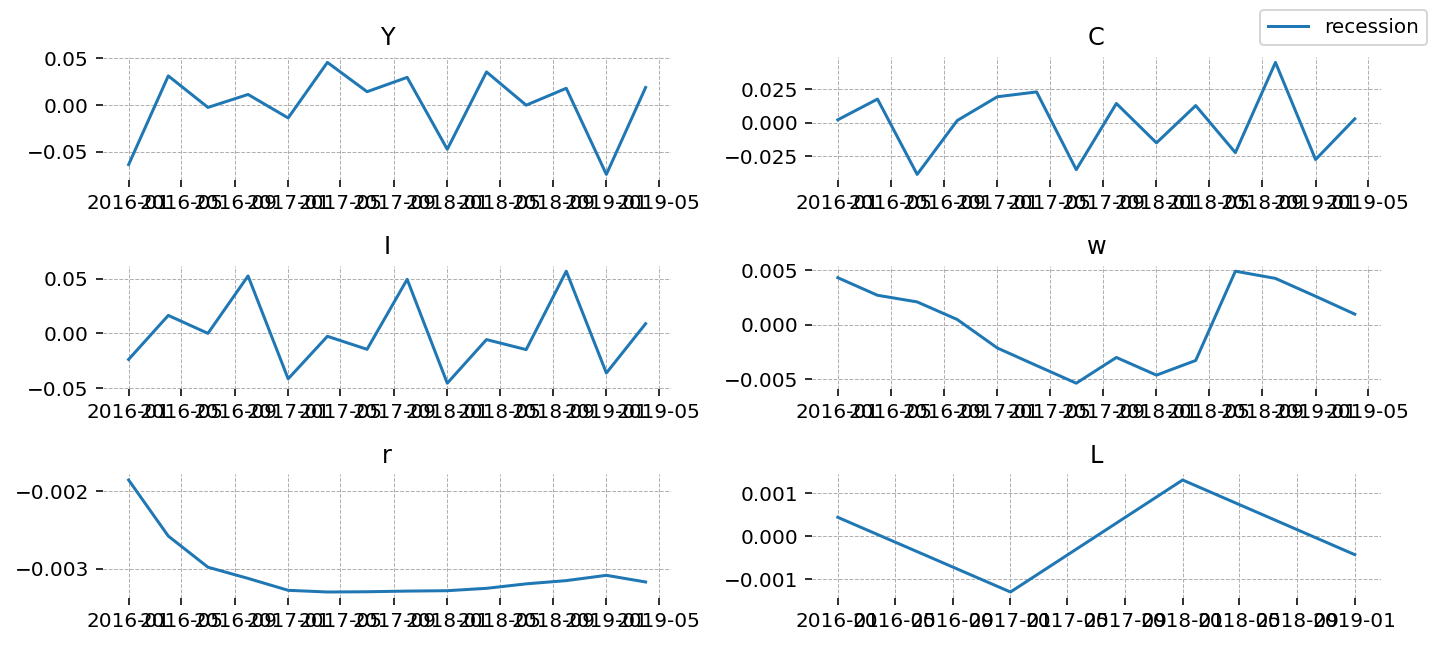

In [16]:
plot_df(test)

### Deseasonalize the Data <a class="anchor" id="section_3_2"></a>

In [17]:
_train = train.copy()
_test = test.copy()

#### HP Filter <a class="anchor" id="subsection_2"></a>

In [18]:
for col in glob_cols:
    _train[col] = get_seasonal_hp(train[col], lamb=6.25, skipna=True)
    _test[col] = get_seasonal_hp(test[col], lamb=6.25, skipna=True)

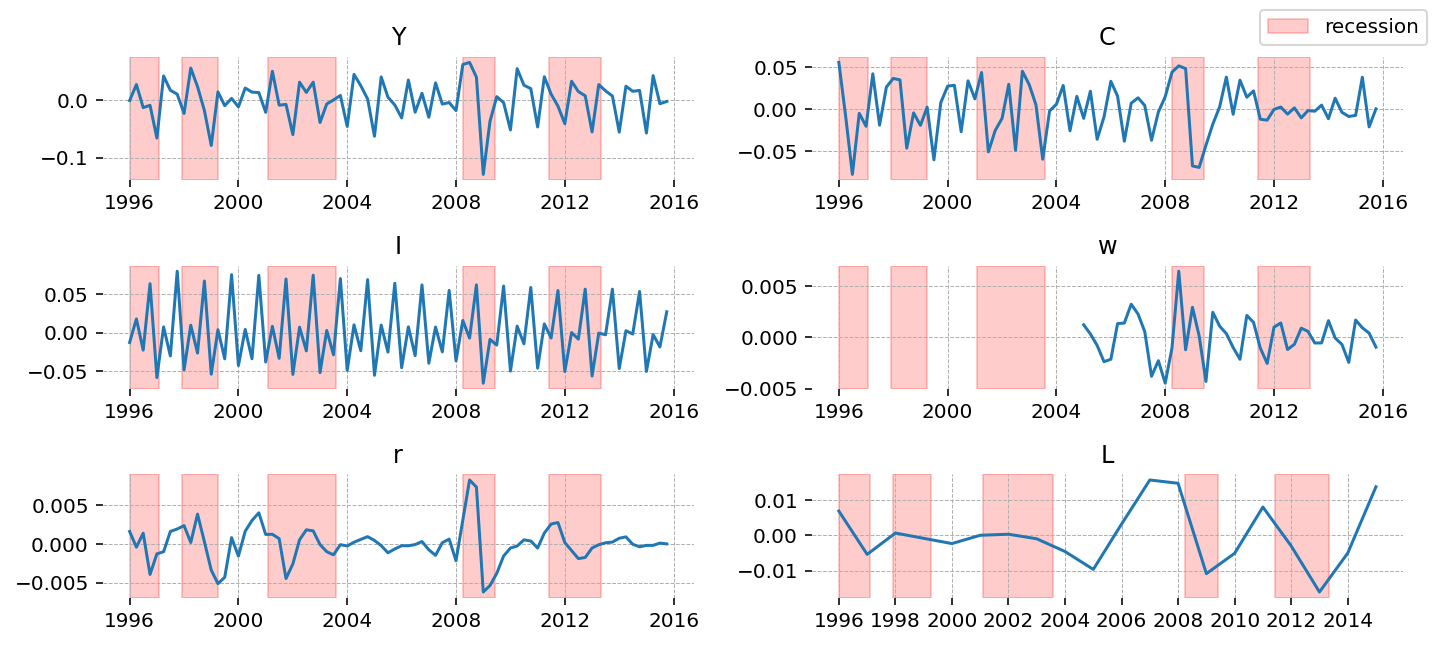

In [19]:
plot_df(_train, recs)

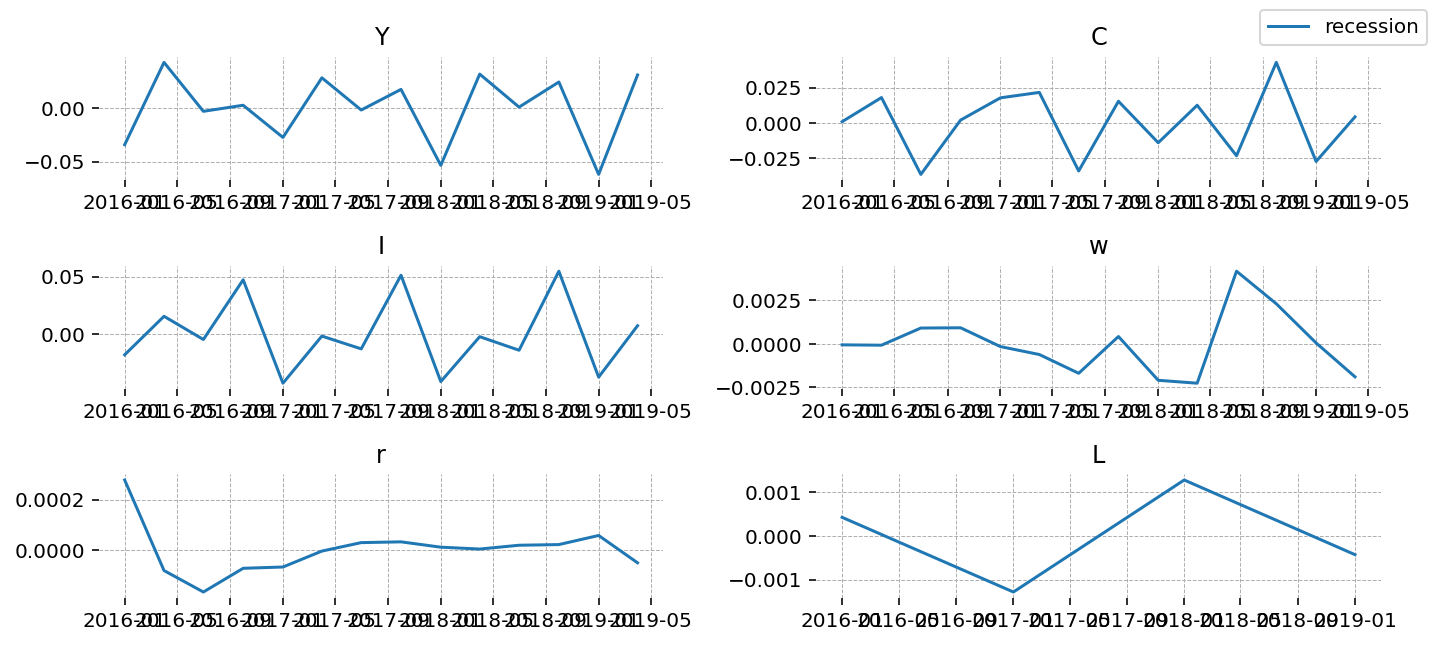

In [20]:
plot_df(_test)

In [21]:
### check stationarity
# 'no constant' is the p-val of interest
ADF_test_summary(_train.drop('w', axis=1), missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -3.259         -5.565        0.000          8    -4.092      -3.474     -3.164
	Constant             0.001          0.228        0.820
	Trend               -0.000         -0.277        0.783
Constant Only               -3.252         -5.601        0.000          8    -3.526      -2.903     -2.589
	Constant            -0.000         -0.025        0.980
No Constant                 -3.253         -5.648        0.000          8    -2.598      -1.945     -1.614
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

#### OLS method <a class="anchor" id="subsection_1"></a>

In [22]:
# r is also seasonal as real r might fluctuate with inflation (which it self is seasonal) while CB holds i constant
# L is by definition not seasonal as only yearly data is available 
for col in [item for item in glob_cols if item != "L"]: 
    model = OLS_dummie_deseasonal()
    _train[col] = model.get_trend(train[col])
    _test[col] = model.predict(test[col])

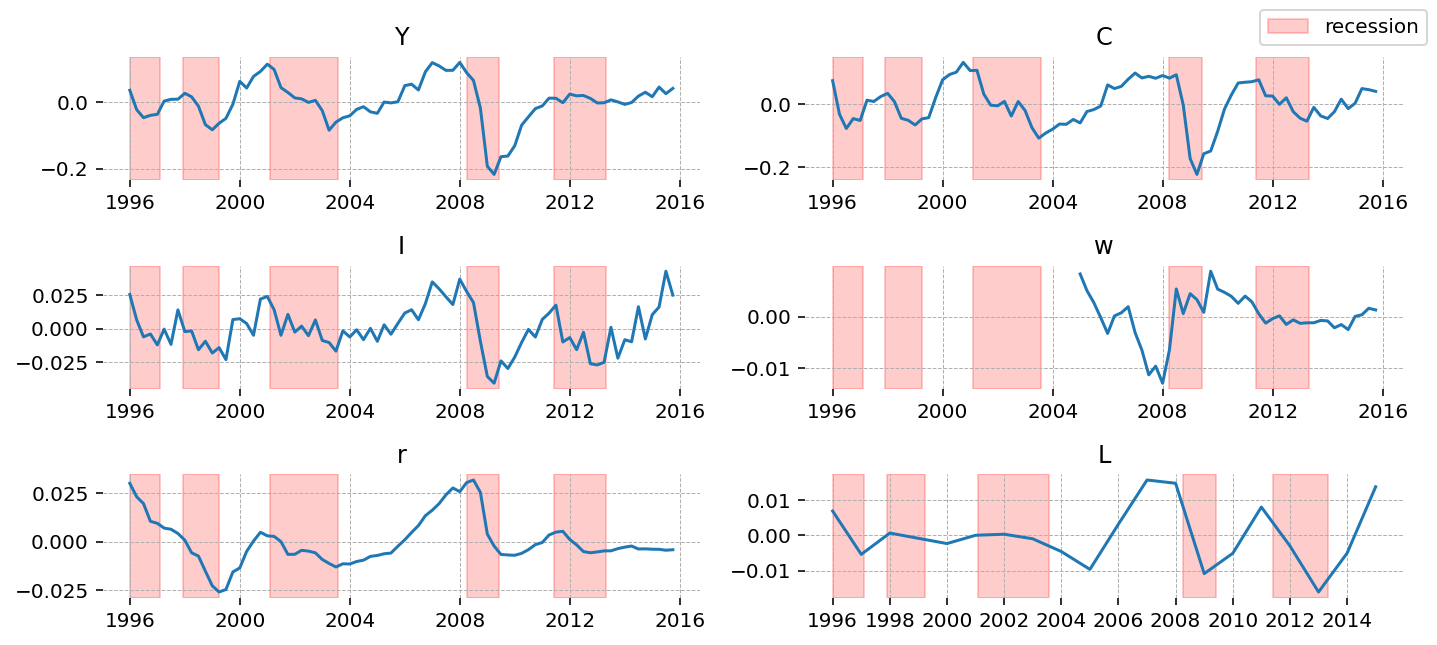

In [23]:
plot_df(_train, recs)

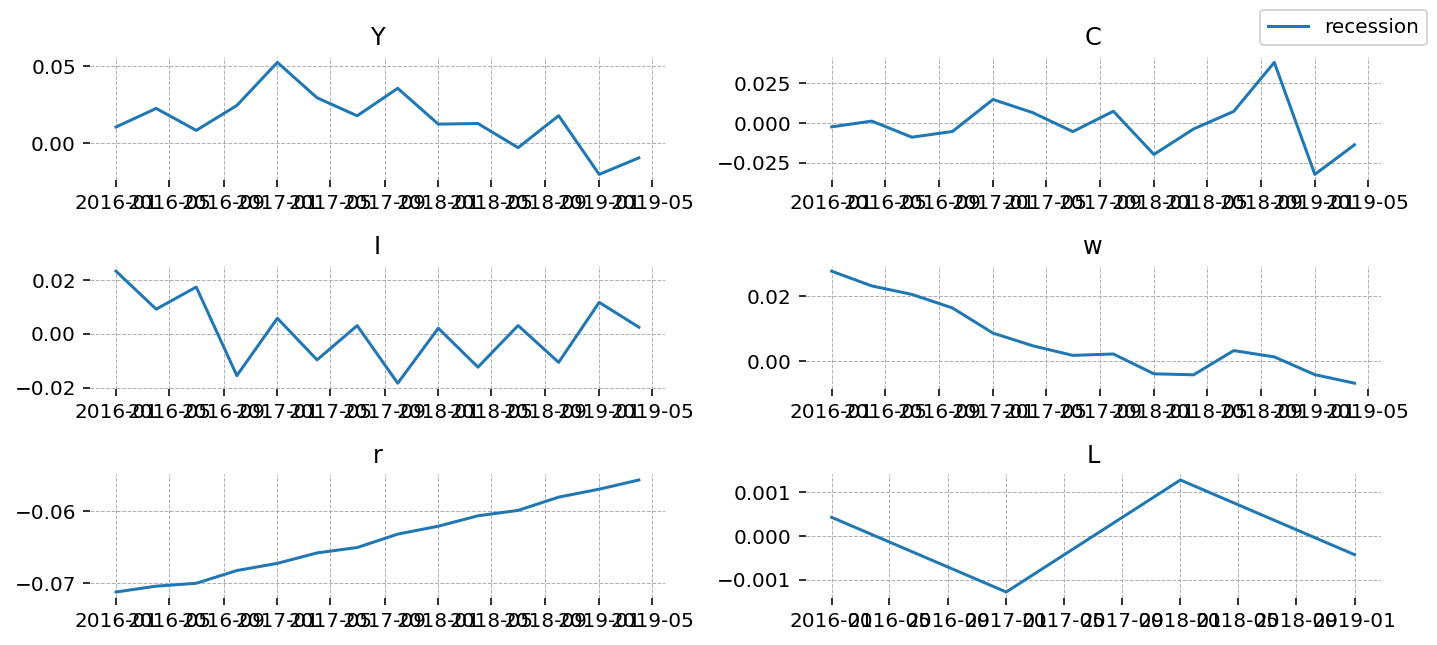

In [24]:
plot_df(_test)

In [25]:
### check stationarity
ADF_test_summary(_train.drop('w', axis=1), missing='drop')

                                                      Y                                                       
Specification               Coeff          Statistic     P-value      Lags      1%          5%        10%
--------------------------------------------------------------------------------------------------------------
Constant and Trend          -0.183         -3.501        0.039          1    -4.080      -3.468     -3.161
	Constant             0.001          0.160        0.873
	Trend               -0.000         -0.066        0.948
Constant Only               -0.183         -3.524        0.007          1    -3.517      -2.899     -2.587
	Constant             0.001          0.210        0.834
No Constant                 -0.183         -3.550        0.000          1    -2.595      -1.945     -1.614
                                                      I                                                       
Specification               Coeff          Statistic     P-value      La

Analyzing the output of the augmented Dickey-Fueller test after processing the data, it is possible to see that with the exception of Labour, all the other variables are stationary. The problem with labour is in fact the standard deviation which is very low, but observing the plot, we can see that also this variable could be considered as stationary.

We decided in the end for regression instead of the HP filter, as the HP filter was unable to detect and remove the strong seasonality in I.

In [27]:
# SARIMA to deseasonalise and detrend ??
from statsmodels.tsa.statespace.sarimax import SARIMAX

_train = _train.asfreq('QS')

model = SARIMAX(_train.Y, order=(1,1,0))

model.fit()
# model.

In [28]:
train = _train.copy()
test = _test.copy()

In [29]:
#save data
train.reset_index().to_csv(os.path.join(DATA_DIR, 'train.csv'))
test.reset_index().to_csv(os.path.join(DATA_DIR, 'test.csv'))